In [2]:
# 1.1. IMPORT PACKAGES AND SETUP ENVIRONMENT
import snntorch as snn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from snntorch import utils

# Training Parameters
batch_size = 128
data_path = '/tmp/data/mnist'
num_classes = 10
# MNIST has 10 output classes

# Torch Variables
dtype = torch.float

# 1.2 DOWNLOAD DATASET
# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

# Try to download MNIST dataset
try:
    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
except Exception as e:
    print(f"Error downloading MNIST dataset: {e}")
    print("Attempting to download using alternative method...")
    # Uncomment the following lines if the direct download fails
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    # mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)

# Reduce the dataset size
subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

# 1.3 CREATE DATALOADERS
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# 2.3 LATENCY CODING OF MNIST
def convert_to_time(data, tau=5, threshold=0.01):
    spike_time = tau * torch.log(data / (data - threshold))
    return spike_time

The size of mnist_train is 6000


In [3]:
import torch
from snntorch import spikegen

def create_rate_coded_vector(num_steps, p_spike=0.5):
    # create vector filled with p_spike
    raw_vector = torch.ones(num_steps) * p_spike

    # pass each sample through a Bernoulli trial
    rate_coded_vector = torch.bernoulli(raw_vector)
    print(f"Converted vector: {rate_coded_vector}")
    print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

def rate_code_mnist_data(train_loader, num_steps):
    """Generate rate-coded samples for MNIST data."""
    data_it, targets_it = next(iter(train_loader))

    # Spiking Data
    spike_data = spikegen.rate(data_it, num_steps=num_steps)
    print(spike_data.size())
    return spike_data, targets_it

In [4]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import display, HTML
import snntorch.spikegen as spikegen
import torch  
from mnist_setup import convert_to_time

def visualize_spike_data(spike_data, targets_it, num_steps=100, ffmpeg_path=None, gain=0.25):
    """Visualize and animate spike data."""
    # Index into a single sample from the batch dimension
    spike_data_sample = spike_data[:, 0, 0]
    print(f"Spike data sample size: {spike_data_sample.size()}")

    # Animation
    fig, ax = plt.subplots()
    anim = splt.animator(spike_data_sample, fig, ax)
    if ffmpeg_path:  # Uncomment if ffmpeg path needs to be set
        plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path

    # Display the animation
    display(HTML(anim.to_html5_video()))

    # Optional: Save the animation
    anim.save(f"spike_mnist_test.mp4")

    # Print the corresponding target label
    print(f"The corresponding target is: {targets_it[0]}")

    # Average spikes over time and reconstruct input images
    plt.figure(facecolor="w")
    plt.subplot(1,2,1)
    plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
    plt.axis('off')
    plt.title(f'Average Spike Visualization')
    plt.title('Gain = 0.25')

    # plt.subplot(1,2,2)
    # plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
    # plt.axis('off')
    # plt.title(f'Spike Visualization With Grain = 0.25')
    # plt.title('Gain = 0.25')

    plt.show()

    # Reshape spike_data_sample for raster plot
    spike_data_sample2 = spike_data_sample.reshape((num_steps, -1))

    # Generate raster plot
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)
    splt.raster(spike_data_sample2, ax, s=1.5, c="black")

    plt.title("Input Layer")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()
    idx = 210  # index into the 210th neuron

    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)

    splt.raster(spike_data_sample2.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

    plt.title("Input Neuron")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.show()

def visualize_latency_coding():
    raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
    spike_times = convert_to_time(raw_input)  # Assuming convert_to_time is accessible

    plt.plot(raw_input, spike_times)
    plt.xlabel('Input Value')
    plt.ylabel('Spike Time (s)')
    plt.title('Latency Coding Visualization')
    plt.show()

#  visualize_latency_coding()
def visualize_raster_plot_latency(spike_data_sample, num_steps=100, tau=5, threshold=0.01, clip= True, normalize=True, linear=True):
    # Reshape spike_data_sample for raster plot
    spike_data_sample3 = spike_data_sample.reshape((num_steps, -1))

    # Generate raster plot
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)
    splt.raster(spike_data_sample3, ax, s=25, c="black")

    plt.title("Latency Coded Input Layer")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()


def visualize_delta_modulation():
    # Create a tensor with some fake time-series data
    data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])
    
    # Plot the tensor
    plt.plot(data)
    plt.title("Some fake time-series data")
    plt.xlabel("Time step")
    plt.ylabel("Voltage (mV)")
    plt.show()
    
    # Convert data with delta modulation
    spike_data = spikegen.delta(data, threshold=4)
    
    # Create fig, ax for raster plot of delta converted data
    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)
    splt.raster(spike_data, ax, c="black")
    
    plt.title("Input Neuron")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.xlim(0, len(data))
    plt.show()

    # Convert data considering off spikes as well
    spike_data_off = spikegen.delta(data, threshold=4, off_spike=True)
    
    # Raster plot for delta converted data with off spikes
    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)
    splt.raster(spike_data_off, ax, c="black")
    
    plt.title("Input Neuron with Off Spikes")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.xlim(0, len(data))
    plt.show()
    
    # Print the tensor to show the presence of “off-spikes”
    print(spike_data_off)











The size of mnist_train is 6000


In [6]:
# Training Parameters
batch_size = 128
data_path = '/tmp/data/mnist'

# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# MNIST dataset
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Temporal Dynamics
num_steps = 100

spike_data, targets_it = rate_code_mnist_data(train_loader, num_steps)





torch.Size([100, 128, 1, 28, 28])


Converted vector: tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
The output is spiking 53.00% of the time.
torch.Size([100, 128, 1, 28, 28])
Spike data sample size: torch.Size([100, 28, 28])


The corresponding target is: 0


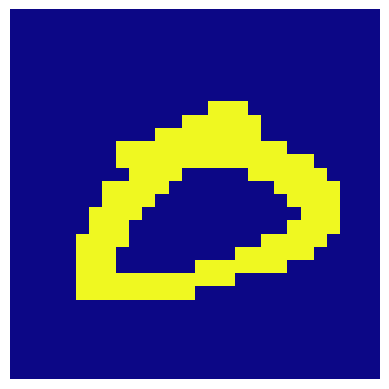

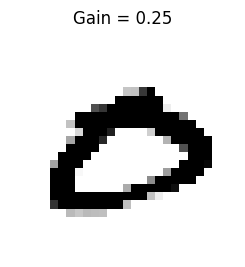

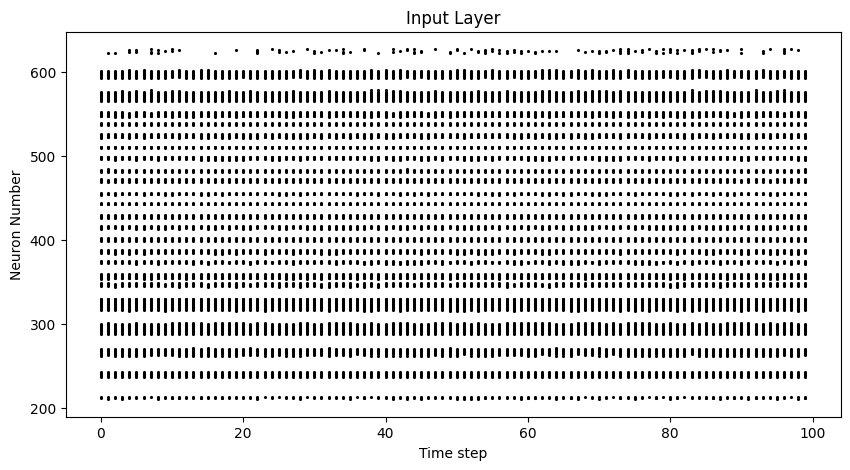

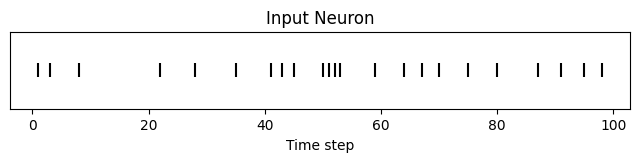

In [7]:
# Rate coding experiments
# rate_coding.create_rate_coded_vector(10)  # Example with num_steps=10
create_rate_coded_vector(num_steps)  # Example with num_steps=100
rate_code_mnist_data(train_loader, num_steps)


# Visualization and Animation
# Assuming spike_data and targets_it are available from the rate coding part
# visualize_spike_data(spike_data, targets_it, num_steps=100, gain=1.0)  # For original gain
visualize_spike_data(spike_data, targets_it, 100, ffmpeg_path='/usr/bin/ffmpeg', gain=0.25)
# visualize_spike_data(spike_data, targets_it, num_steps=100)  # Visualize with default settings
# visualize_spike_data(spike_data, targets_it, num_steps=100, gain=0.25)  # For reduced gain

# spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)



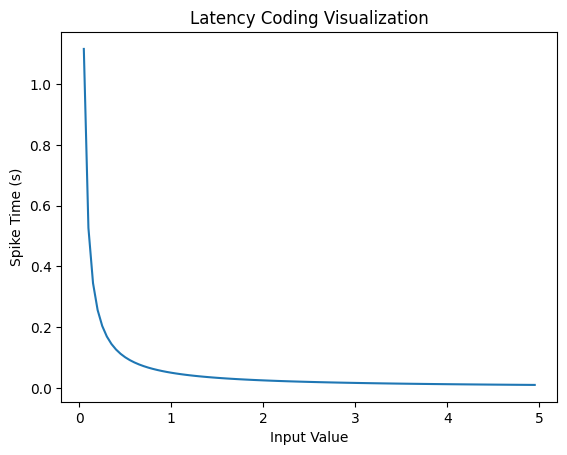

In [8]:
# Example code snippet for applying latency coding to MNIST data
for data, target in train_loader:
    spike_times = convert_to_time(data, tau=5, threshold=0.01)
   
visualize_latency_coding()





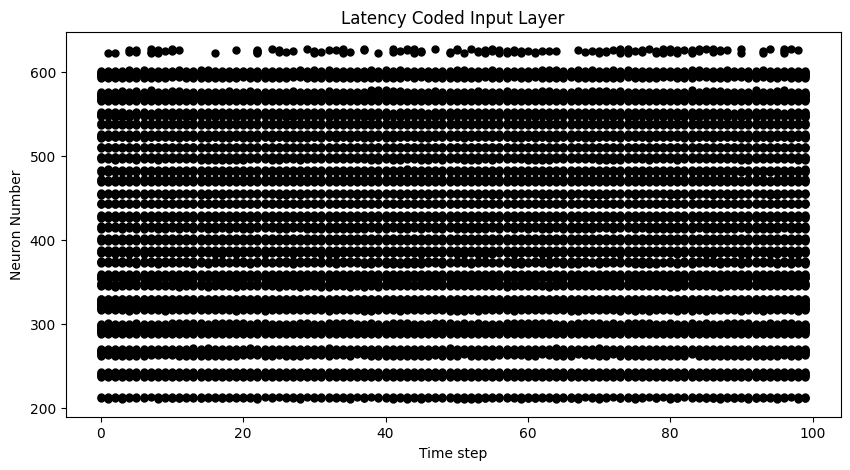

In [9]:

num_steps = 100
tau = 5
threshold = 0.01
clip = True
normalize = True
linear = True
spike_data_sample3 = spike_data[:, 0].view(num_steps, -1)

# Call the visualization function for the raster plot
# visualize_raster_plot_latency(spike_data_sample3, num_steps)

visualize_raster_plot_latency(spike_data_sample3, num_steps=num_steps, tau=tau, threshold=threshold, clip=clip, normalize=normalize, linear=linear)



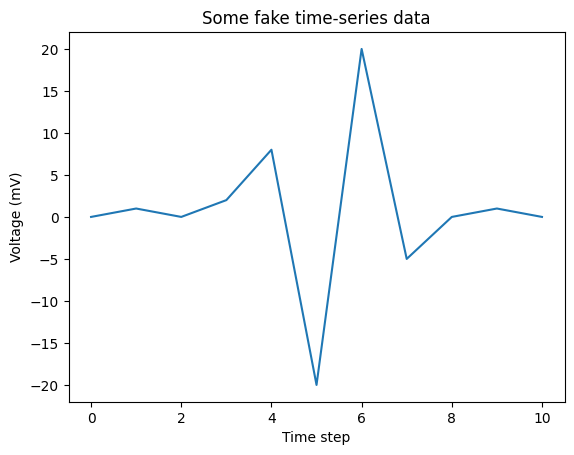

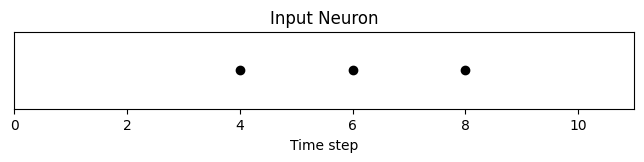

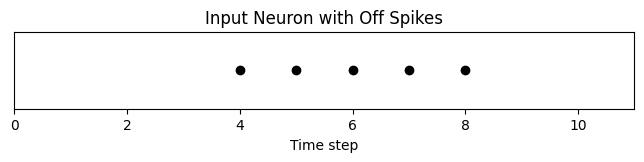

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


In [10]:

visualize_delta_modulation()